# TAR PROJECT - TEXT SEGMENTATION

### Authors: Mirela Oštrek and Luka Dulčić

In [12]:
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
import string
import os
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Helper functions

In [13]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stemmer = PorterStemmer()
# irrelevant characters specific for choi dataset
choi_noise = ['--', '\'\'', '``', ';', '..', '...', 'afj']

def is_digit(string):
    return string.replace('.', '').replace('-', '').replace(',', '').isdigit()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = list(map(lambda t: t.lower(), tokens))
    tokens = filter(lambda t: t not in string.punctuation, tokens)
    tokens = filter(lambda t: t not in ENGLISH_STOP_WORDS, tokens)
    tokens = filter(lambda t: not is_digit(t), tokens)
    tokens = filter(lambda t: t not in choi_noise, tokens)
    tokens = filter(lambda t: t[0] != '\'', tokens)#remove strings like "'s" 
    stems = stem_tokens(tokens, stemmer)
    return stems

def get_filepaths(directory):

    file_paths = []

    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)

    return file_paths

def doc_to_seg_string(n_sent, boundaries):
    '''
    Creates string which represents documents (eg. '0000100001000')
    where 0 marks sentence and 1 marks boundary between segments.
    This string is used for evaluating topic tiling algorithm with Pk
    and WD measure.
    
    @param n_sent: number of sentences in document.
    @param boundaries: indices of boundaries between segments
    '''
    seg_string = ''
    for i in range(n_sent):
        if i in boundaries:
            seg_string += '1'
        else:
            seg_string += '0'
    return seg_string

def print_top_words(model, feature_names, n_top_words):
    '''
    Prints top words for each topic where "model" is LDA model.
    '''
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def max_left(sequence, ind_curr):
    max = sequence[ind_curr]
    while (ind_curr != 0) and (max <= sequence[ind_curr-1]):
        max = sequence[ind_curr-1]
        ind_curr -= 1 
    return max

def max_right(sequence, ind_curr):
    max = sequence[ind_curr]
    while (ind_curr != (len(sequence)-1)) and (max <= sequence[ind_curr+1]):
        max = sequence[ind_curr+1]
        ind_curr += 1  
    return max

Loading dataset

In [14]:
class Document:
    """
    Document represents one document from choi dataset.
    :param sentences: list of document sentences
    :param boundaries: list of positions where segments boundaries are 
                        (note: boundary 0 means segment boundary is behind sententence at index 0)
    :param segment_divider: string which indicates boundary between two segments
    """
    
    def __init__(self, path):
        """
        :param path: Path to file where documents is.
        """
        self.path = path
        self.sentences = []
        self.boundaries = []
        self.segment_divider = "=========="
        
        self.load_document(path)
        
    def load_document(self, path):
        """
        :param path: Path to file where document is.
        """
        sentences = self.get_valid_sentences(path)
        for i, sentence in enumerate(sentences):
            if sentence != self.segment_divider:
                self.sentences.append(sentence)
            else:
                self.boundaries.append(i - len(self.boundaries) - 1)
        #remove unecessary boundaries at beginning and the end
        del self.boundaries[0]
        del self.boundaries[-1]
        
    def get_valid_sentences(self, path):
        """
        Reads all sentences from file and filters out invalid ones.
        Invalid sentences are sentences which are empty or contain
        only irrelevant tokens like stop words, punctuations, etc.
        """
        sentences = []
        with open(path, 'r') as fd:
            for line in fd:
                line = line.rstrip('\n')
                if tokenize(line):
                    # if line is valid
                    sentences.append(line)
        return sentences
        
    
    def to_text(self):
        """
        Returns this documents as appendend string of sentences.
        """
        return '\n'.join(self.sentences)
    
    def to_segments(self):
        """
        Returns this document as list of segments based on boundaries.
        """
        segments = []
        for i, boundary in enumerate(self.boundaries):
            if i == 0:
                segments.append(' '.join(self.sentences[0:boundary]))
            else:
                last_b = self.boundaries[i - 1]
                segments.append(' '.join(self.sentences[last_b:boundary]))
        segments.append(' '.join(self.sentences[self.boundaries[-1]:]))
        return segments

In [83]:
files_paths = get_filepaths('choi_data')
documents = [Document(path) for path in files_paths]

## Topic Tiling

In [79]:
from scipy import spatial
from scipy.signal import argrelextrema

class TopicTiling:
    """
    Implementation of Topic Tiling algorithm (M. Riedl and C. Biemann. 2012, Text Segmentation with Topic Models) 
    """
    
    def __init__(self, m = 0.5):
        """
        :param m: Multiplier of standard deviation in condition for segmentation (c = mean - m*stddev).
        :param cosine_similarities: Cosine similarities between sentences.
        :param boundaries: Caluclated segments boundaries.
        """
        self.m = m
        self.cosine_similarities = None
        self.boundaries = None
        
    def fit(self, sentence_vectors):
        """
        Runs Topic Tiling algorithm on list of sentence vectors.
        
        :param sentence_vectors: List (iterable) of topic distributions for each sentence in document.
                                 t-th element of sentence vector is weight for t-th topic for sentence, 
                                 higher weight means that sentence is "more about" t-th topic.
                                 
        :return: Calculated boundaries based on similatities between sentence vectors.
                 Note: boundary '0' means that segment boundary is behind sentence which is at index 0
                 in sentence_vectors.
        """
        self.cosine_similarities = np.empty(0)
        depth_scores = []

        # calculating cosine similarities
        for i in range(0, len(sentence_vectors) - 1):
            sim = 1 - spatial.distance.cosine(sentence_vectors[i], sentence_vectors[i+1])
            self.cosine_similarities = np.append(self.cosine_similarities, sim)

        # get all local minima
        split_candidates_indices = argrelextrema(self.cosine_similarities, np.less_equal)[0]

        # calculating depth scores
        for i in split_candidates_indices:
            depth = 1/2 * (max_left(self.cosine_similarities, i) + max_right(self.cosine_similarities, i) - 2 * self.cosine_similarities[i])
            depth_scores.append((depth, i))

        tmp = np.array(list(map(lambda d: d[0], depth_scores)))
        
        # calculate segment threshold condition
        condition = tmp.mean() - self.m*tmp.std()
        
        # determine segment boundaries
        tmp = filter(lambda d: d[0] > condition, depth_scores)
        self.boundaries = [d[1] for d in tmp]
        
        return self.boundaries
    
    def set_m(self, m):
        if m:
            self.m = m

In [59]:
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.metrics.segmentation import pk
from nltk.metrics.segmentation import windowdiff
from time import time

class SegmentationEngine(BaseEstimator):
    """
    Implementation of segmentation engine used for segmenting documents.
    Based on Latent Dirichlet Allocation model and Topic Tiling algorithm.
    :param vectorizer: CountVectorizer class used for transforming and cleaning input data.
    :param lda: Latent Dirichlet Allocation model.
    :param tt: Topic Tiling.
    :param n_topics: Number of topics parameter of LDA.
    :param max_iter: Maximum number of iterations parameter of LDA.
    :param a: Document topics prior parameter of LDA.
    :param b: Topic document prior parameter of LDA.
    :param m: Multiplier parameter of Topic Tiling
    :param random_state: Random state.
    """
    
    def __init__(self, n_topics = 10, max_iter = None, a = None, b = None, m = None, random_state = None):
        """
        Initializes estimator.
        """
        self.n_topics = n_topics
        self.max_iter = max_iter
        self.a = a
        self.b = b
        self.m = m
        self.random_state = random_state
        
        self.vectorizer = CountVectorizer(max_df=0.95, min_df=2, tokenizer=tokenize, stop_words='english')
        self.lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=max_iter, doc_topic_prior=a, topic_word_prior=b, random_state=random_state)
        self.tt = TopicTiling(m=m)
        
    def fit(self, documents):
        """
        Trains segmentation engine.
        :param documents: List (iterable) of strings. 
        """
        print(self.get_params())
        t0 = time()
        
        train_data = self.parse_data(documents)
        X = self.vectorizer.fit_transform(train_data)
        self.lda.fit(X)
        self.tt.fit(self.doc_to_sentence_vectors(documents))
        
        print('Fitted in %0.2f seconds' % (time() - t0))
        
    def predict(self, documents):
        """
        Calculates segment boundaries for all documents.
        :param documents: List (iterable) of documents (class Document).
        :return: List of boundaries for each document.
        """
        # TODO check if fit has been called
        estimated_boundaries = []
        for document in documents:
            sentence_vectors = [self.lda.transform(self.vectorizer.transform([sentence])) for sentence in document.sentences]
            estimated_boundaries.append(self.tt.fit(sentence_vectors))
        return estimated_boundaries
    

    def score(self, X):
        '''
        Calculates segmentation score with Pk or WindowDiff measure. This method uses boundaries
        previously calculated with 'fit' method and gold boundaries gives as 'ref_boundaries'.
        By default this method uses Pk measure.
        
        '''
        scores = np.empty(0)
        estimated_boundaries = self.predict(X)
        for i, document in enumerate(X):
            ref_doc = doc_to_seg_string(len(document.sentences), document.boundaries)
            estimated_doc = doc_to_seg_string(len(document.sentences), estimated_boundaries[i])
            if pk(ref_doc, estimated_doc) > 0.4:
                print(document.path)
            scores = np.append(scores, pk(ref_doc, estimated_doc))
        return 1 - scores.mean()    
                
                
    def set_params(self, **params):
        """
        Sets value of parameters.
        :param params: Dictionary of parameters to be set.
        """
        super(SegmentationEngine, self).set_params(**params)

        # refresh parameters
        self.lda.set_params(n_topics=self.n_topics, max_iter=self.max_iter, doc_topic_prior=self.a, topic_word_prior=self.b, random_state=self.random_state)
        self.tt.set_m(self.m)
        return self
        
    def parse_data(self, documents):
        train_data = []
        for document in documents:
            train_data.extend(document.to_segments())
        return train_data
    
    def doc_to_sentence_vectors(self, documents):
        docs = []
        for document in documents:
            docs.append([self.lda.transform(self.vectorizer.transform([sentence])) for sentence in document.sentences])
        return docs

In [82]:
engine = SegmentationEngine(max_iter=100, a=0.1, b=0.01, m=0.5, random_state=273)

In [20]:
from sklearn.cross_validation import train_test_split

X_train, X_test = train_test_split(documents, test_size = 0.2, random_state = 273)

### WARNING! Very slow block

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

cv = ShuffleSplit(len(X_train), n_iter=1, test_size=.2)

params = {'n_topics': list(range(40, 130, 20)), 'a': np.arange(0.1, 1.1, 0.2), 'm': np.arange(0.4, 1.1, 0.1)}
clf = GridSearchCV(engine, params, cv=cv)

t = time()
clf.fit(X_train)
print('Duration %f' % ((time() - t)/3600))

### Graph

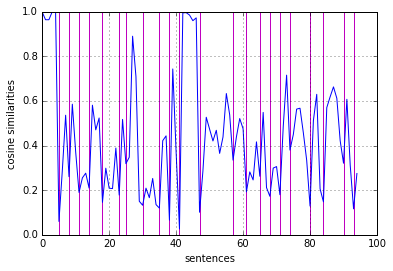

000001000000010000000000001000000000001001000001000000000100000000001000000000001000000000000000
000001001001001000100001010000100001001001000001000000000100010001001001001000001000100000100100
Pk measure result 0.434783
WD measure result 0.586957


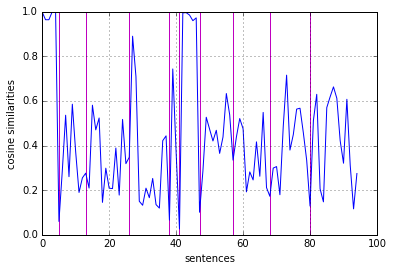

In [51]:
import matplotlib.pyplot as plt

plt.plot(range(0, len(clf.best_estimator_.tt.cosine_similarities)), clf.best_estimator_.tt.cosine_similarities)
plt.vlines(plot_indices, 0, 1, 'm')
plt.xlabel("sentences")
plt.ylabel("cosine similarities")
plt.grid()
plt.show()

ref_doc = doc_to_seg_string(len(doc.sentences), doc.boundaries)
estimated_doc = doc_to_seg_string(len(doc.sentences), plot_indices[0])

print(ref_doc)
print(estimated_doc)

k = int(round(len(ref_doc) / (ref_doc.count('1') * 2.)))

print('Pk measure result %f' % pk(ref_doc, estimated_doc))
print('WD measure result %f' % windowdiff(ref_doc, estimated_doc, k))

plt.plot(range(0, len(clf.best_estimator_.tt.cosine_similarities)), clf.best_estimator_.tt.cosine_similarities)
plt.vlines(doc.boundaries, 0, 1, 'm')
plt.xlabel("sentences")
plt.ylabel("cosine similarities")
plt.grid()
plt.show()